# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

⚙️ 呼叫策略：symbol=ETHUSDT, interval=1d, end_time=2025-07-27 04:37:28.650107, protocol=ethereum, window=5


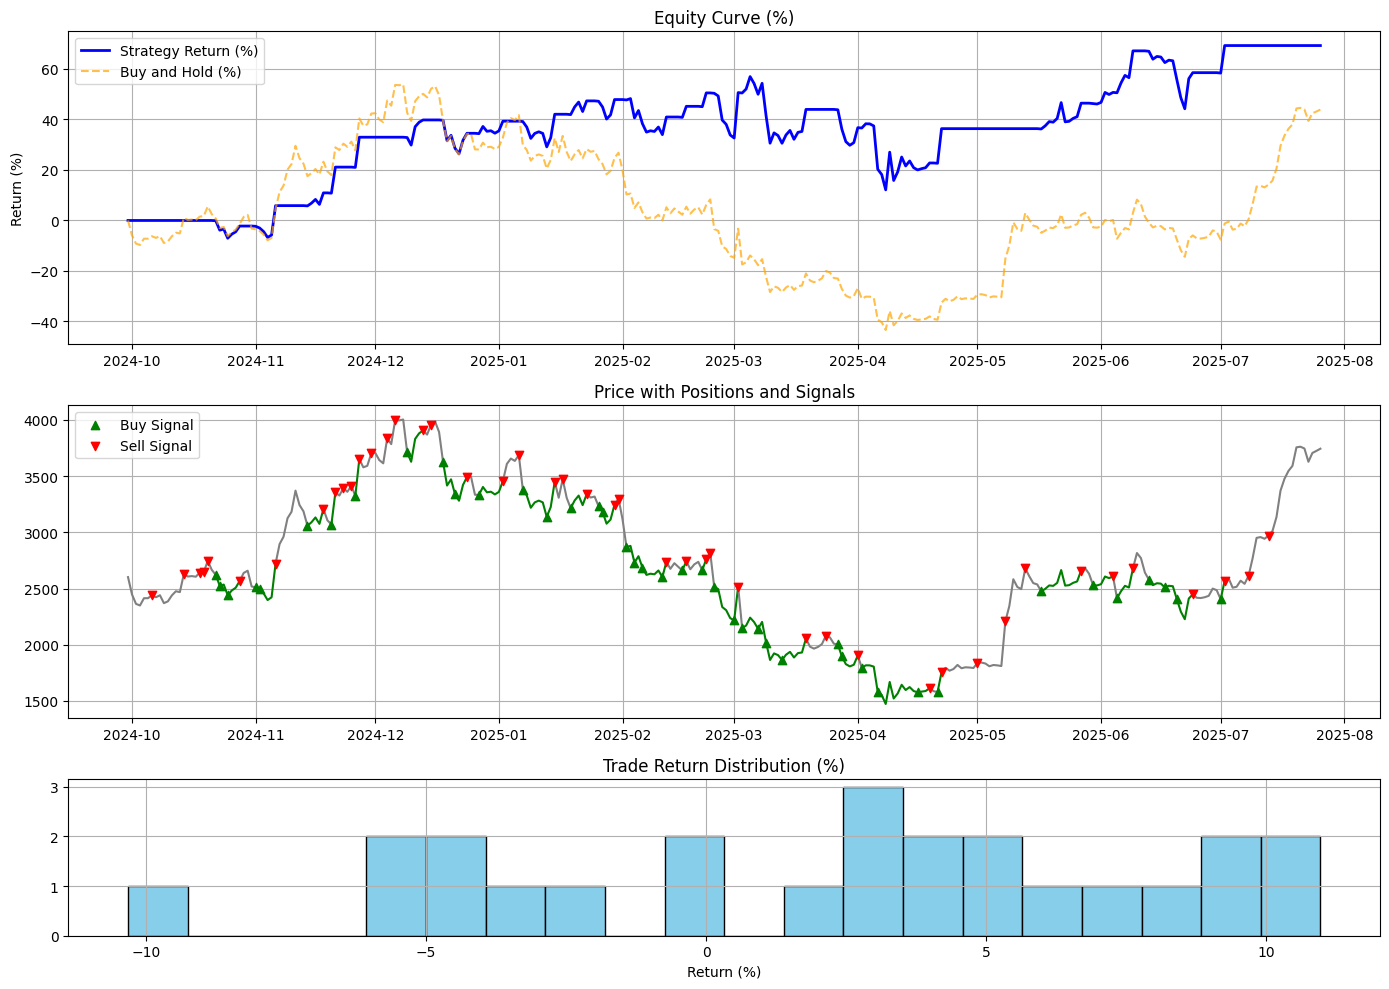

In [1]:
import Technicalindicatorstrategy
from datetime import datetime
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import warnings 
warnings.filterwarnings('ignore')

strategies = "tvl_sma"
strat_module = getattr(Technicalindicatorstrategy, strategies)

class StrategyWrapper:
    def __init__(self,protocol='ethereum',window=5):
        self.protocol = protocol
        self.window = window

    def get_signals(self, symbol, interval, end_time):
        print(f"⚙️ 呼叫策略：symbol={symbol}, interval={interval}, end_time={end_time}, "
              f"protocol={self.protocol}, window={self.window}")
        return strat_module.get_signals(symbol, interval, end_time, protocol=self.protocol,window=self.window)

strategy = StrategyWrapper(protocol='ethereum',window=5)

df_signals = strategy.get_signals("ETHUSDT", "1d", datetime.now())
result = backtest_signals(df_signals, 
                        initial_capital=100, 
                        fee_rate=0.001, 
                        leverage=1, 
                        allow_short=False)
plot_backtest_result(result)


[Gemini] Ethereum ETFs soar past Bitcoin in new flows as institutional focus shifts → positive
[Gemini] BlackRock’s Ethereum ETF Rockets to $10B, Third-Fastest in History → positive
[Gemini] Tether Freezes $1.6 Million USDT Linked to Gaza Network → negative
[Gemini] Ethereum whales and SharpLink gaming accumulate $400M+ in ETH amid market consolidation → positive
[Gemini] XRP Is Now Poised For Bigger Gains Than Ethereum → positive
[Gemini] Ripple to unlock 1 billion XRP on August 1; Incoming sell-off? → negative
[Gemini] Ethereum ETFs See $4 Billion Of Inflows As Rally Gathers Steam → positive
[Gemini] Ethereum Treasury Company Trend 'Will Accelerate', Says Bitwise's Matt Hougan—Here's What It Means For ETH's Price → positive
[Gemini] WLFI Ethereum accumulation hits $19.4M as platform doubles down on ETH → positive
[Gemini] Charles Hoskinson Calls Out ‘Emotional Voting’ in Cardano Ecosystem → negative
[Gemini] Cardano Whale slams Charles Hoskinson, calls for voting revolt → negative
[G

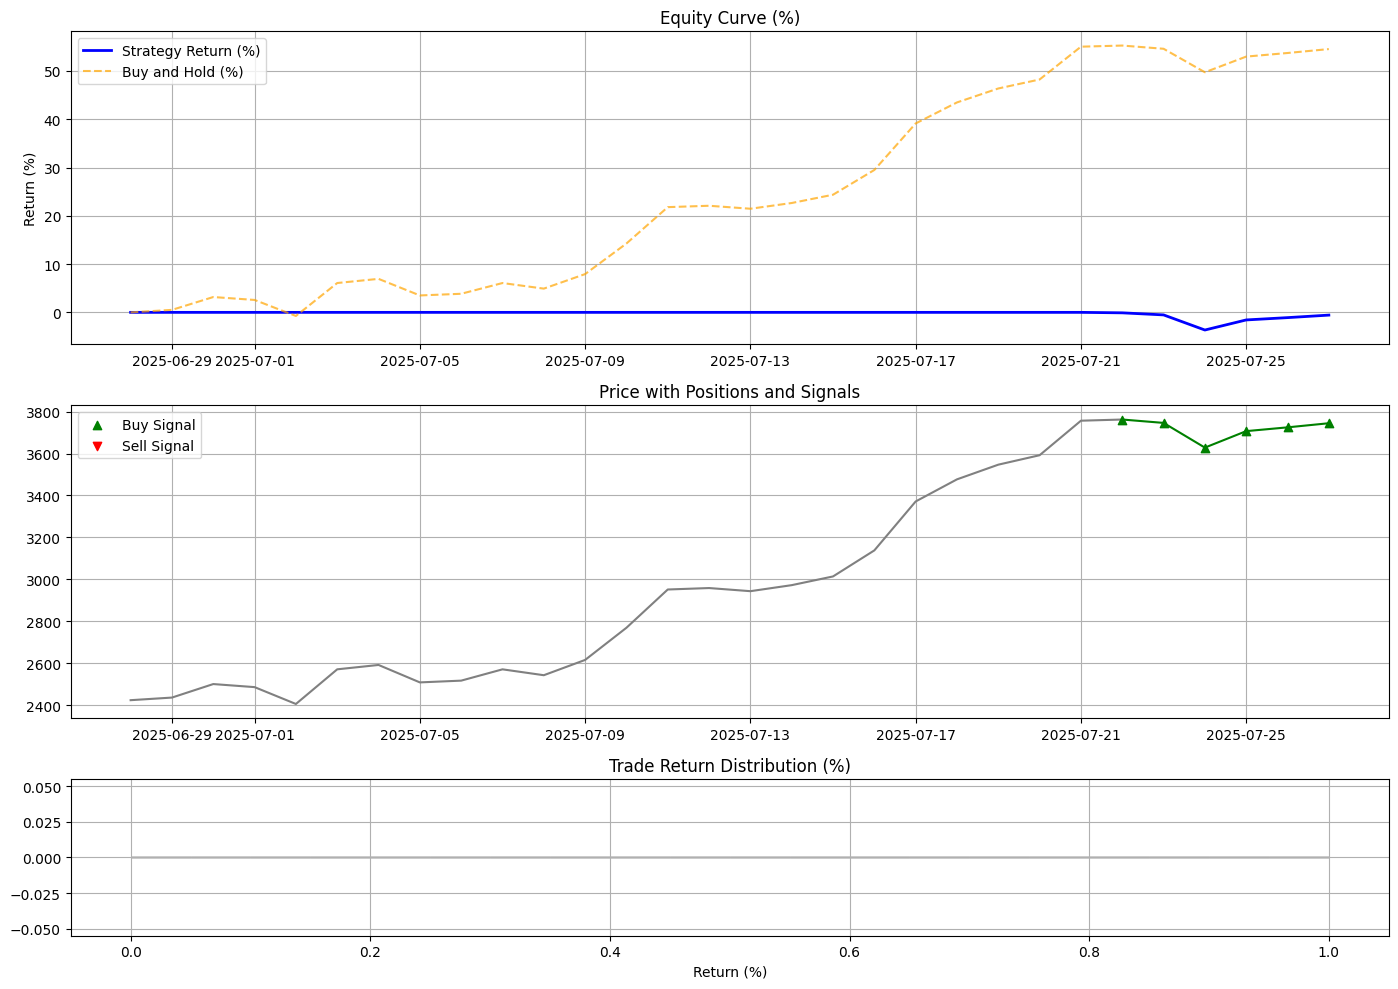

In [2]:
import Technicalindicatorstrategy
from datetime import datetime
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import warnings 
warnings.filterwarnings('ignore')

strategy  = getattr(Technicalindicatorstrategy,"news_sentiment_strategy")

df_signals = strategy.get_signals("ETHUSDT", "1d", datetime.now())
print(df_signals['sentiment_score'].values)
result = backtest_signals(df_signals, 
                        initial_capital=100, 
                        fee_rate=0.001, 
                        leverage=1, 
                        allow_short=False)
plot_backtest_result(result)
